In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import itertools
import collections
import requests
import time
import re
from bs4 import BeautifulSoup
from ydata_profiling import ProfileReport
import os
from tqdm import tqdm
import json
from datetime import datetime
import signal
import sys
import pickle
import concurrent.futures
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import logging
from functools import lru_cache

os.getcwd()
data = pd.read_pickle(r'C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\processed_data\combined_dataset.pkl')
print(f"Dataset shape: {data.shape}")
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates} ({duplicates/len(data):.2%})")

Dataset shape: (49866, 23)
Number of duplicate rows: 0 (0.00%)



Missing values by column (%):
final_worldwide_boxoffice     74.55%
final_budget                  72.27%
final_domestic_boxoffice      69.83%
final_certificate             54.58%
star                          46.42%
star_id                       46.41%
director                      46.40%
director_id                   46.40%
final_runtime                 11.10%
final_overview                10.42%
final_original_language        9.20%
imdb_id                        9.18%
final_rating                   9.18%
production_companies           9.18%
cast                           9.18%
crew                           9.18%
final_production_countries     9.18%
final_genres                   7.43%
release_date                   0.30%
final_year                     0.30%
final_title                    0.00%
final_clean_title              0.00%
_merge                         0.00%
dtype: object


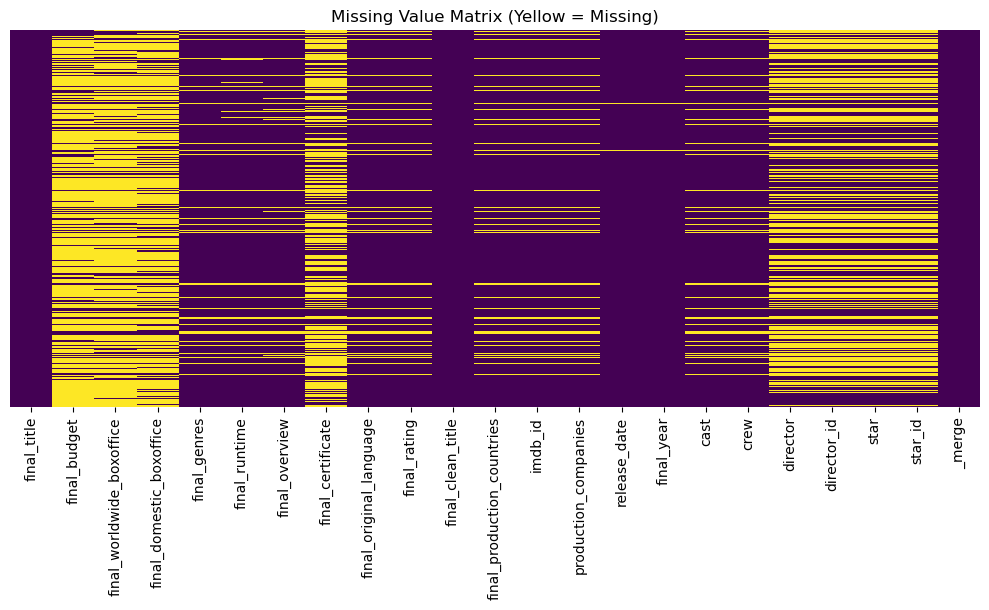

In [6]:
missing = data.isna().mean().sort_values(ascending=False)
print("\nMissing values by column (%):")
print(missing.apply(lambda x: f"{x:.2%}"))

plt.figure(figsize=(10, 6))
sns.heatmap(data.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout()
plt.title('Missing Value Matrix (Yellow = Missing)')
plt.show()


Data types:
final_title                           object
final_budget                         float64
final_worldwide_boxoffice            float64
final_domestic_boxoffice             float64
final_genres                          object
final_runtime                        float64
final_overview                        object
final_certificate                     object
final_original_language               object
final_rating                         float64
final_clean_title                     object
final_production_countries            object
imdb_id                               object
production_companies                  object
release_date                  datetime64[ns]
final_year                           float64
cast                                  object
crew                                  object
director                              object
director_id                           object
star                                  object
star_id                               obje

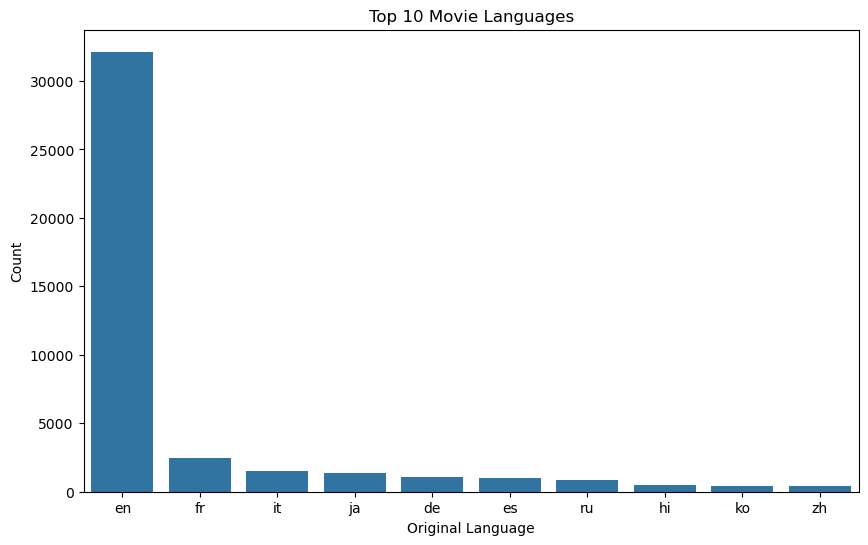

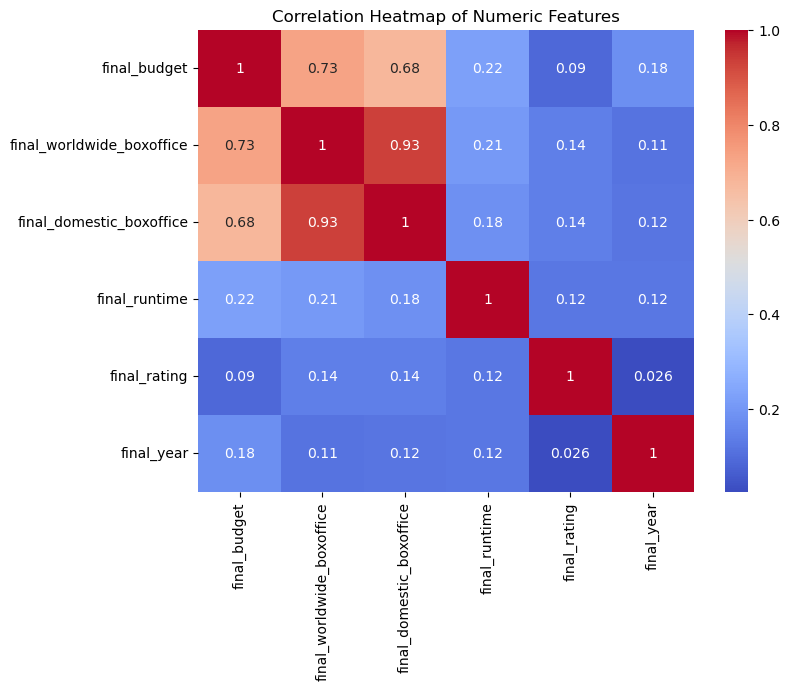

In [11]:
print("\nData types:")
print(data.dtypes)
plt.figure(figsize=(10, 6))
lang_counts = data['final_original_language'].value_counts().head(10)
sns.barplot(x=lang_counts.index, y=lang_counts.values)
plt.title("Top 10 Movie Languages")
plt.xlabel("Original Language")
plt.ylabel("Count")
plt.show()

numeric_cols = ['final_budget', 'final_worldwide_boxoffice', 'final_domestic_boxoffice', 'final_runtime', 'final_rating', 'final_year']
corr = data[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()




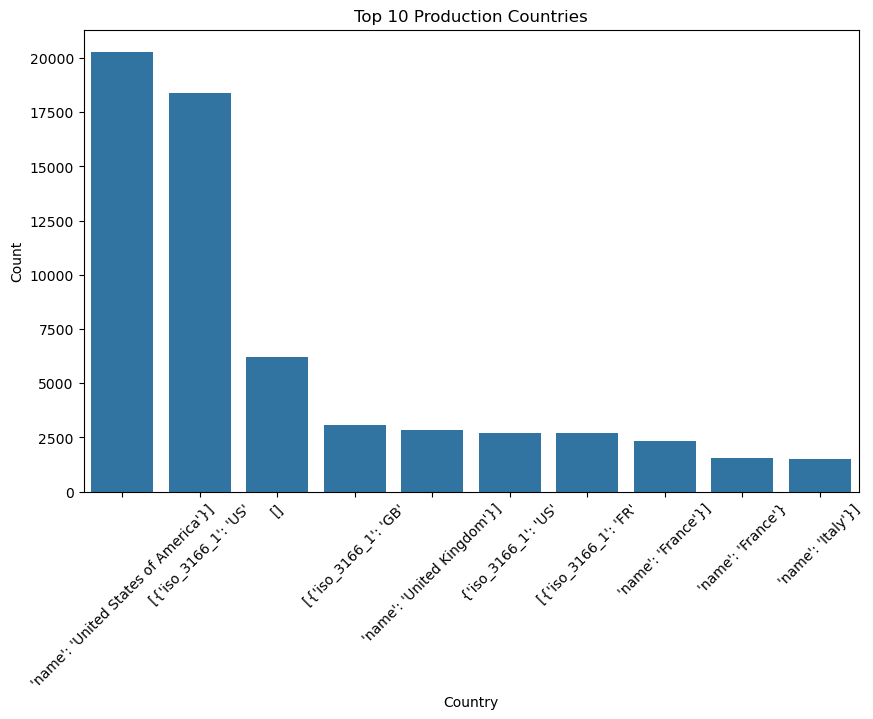

In [ ]:


# Split the production countries for each movie 
countries = data['final_production_countries'].dropna().apply(lambda x: x.split(","))
countries_list = list(itertools.chain.from_iterable(countries))
countries_list = [c.strip() for c in countries_list]
country_counts = collections.Counter(countries_list)
top_countries = pd.DataFrame.from_dict(country_counts, orient="index", columns=["Count"]).sort_values("Count", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.index, y=top_countries["Count"])
plt.title("Top 10 Production Countries")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
class MovieDataEnricher:
    
    
    def __init__(self, api_key=None, max_workers=10, rate_limit=10):
        
        self.api_key = api_key
        self.max_workers = max_workers
        self.rate_limit = rate_limit
        self.last_request_time = 0
        
        
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger('MovieEnricher')
        
        
        self.session = self._create_session()
        
        
        self.stats = {
            'total_movies': 0,
            'api_success': 0,
            'web_success': 0,
            'failed': 0,
            'processed': 0
        }
        
        # For pause/resume
        self.checkpoint_file = None
        self.is_paused = False
        self.processed_indices = set()
        
    def _create_session(self):
       
        session = requests.Session()
        
        # Set a user agent 
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept-Language': 'en-US,en;q=0.9',
        }
        session.headers.update(headers)
        
        #  retry strategy
        retry_strategy = Retry(
            total=3,
            backoff_factor=0.5,
            status_forcelist=[429, 500, 502, 503, 504],
            allowed_methods=["GET"]
        )
        
        # Mount the adapter 
        adapter = HTTPAdapter(
            max_retries=retry_strategy,
            pool_connections=self.max_workers,
            pool_maxsize=self.max_workers
        )
        session.mount("http://", adapter)
        session.mount("https://", adapter)
        
        return session
    
    @lru_cache(maxsize=1000)
    def _extract_year(self, date_value):
        
        if pd.isna(date_value):
            return None
            
        if isinstance(date_value, int) and 1900 <= date_value <= 2030:
            return date_value
            
        if isinstance(date_value, str):
            
            if re.match(r'^(19|20)\d{2}$', date_value):
                return int(date_value)
                
            
            year_match = re.search(r'(19|20)\d{2}', date_value)
            if year_match:
                return int(year_match.group(0))
            
            # various date formats
            for fmt in ('%d-%b-%y', '%Y-%m-%d', '%m/%d/%Y'):
                try:
                    dt = datetime.strptime(date_value, fmt)
                    return dt.year
                except ValueError:
                    continue
        
        if isinstance(date_value, (datetime, pd.Timestamp)):
            return date_value.year
            
        return None
    
    def _rate_limit(self, is_api=False):
   
        min_interval = 1/self.rate_limit if is_api else 2/self.rate_limit
        current_time = time.time()
        elapsed = current_time - self.last_request_time
        
        if elapsed < min_interval:
            time.sleep(min_interval - elapsed)
            
        self.last_request_time = time.time()
    
    def _save_checkpoint(self, movies_df):
        
        if self.checkpoint_file:
            checkpoint_data = {
                'processed_indices': self.processed_indices,
                'stats': self.stats,
                'last_processed_index': max(self.processed_indices) if self.processed_indices else -1
            }
            
            
            movies_df.to_csv(self.checkpoint_file + '.data', index=False)
            
            # Save the checkpoint data
            with open(self.checkpoint_file, 'wb') as f:
                pickle.dump(checkpoint_data, f)
    
    def _load_checkpoint(self):

        if os.path.exists(self.checkpoint_file):
            try:
                with open(self.checkpoint_file, 'rb') as f:
                    checkpoint_data = pickle.load(f)
                
                self.processed_indices = checkpoint_data['processed_indices']
                self.stats = checkpoint_data['stats']
                
                self.logger.info(f"Loaded checkpoint: Previously processed {len(self.processed_indices)} movies.")
                return True
            except Exception as e:
                self.logger.error(f"Error loading checkpoint: {e}")
                return False
        return False
    
    def _handle_interrupt(self, signal, frame):
        
        self.logger.info("\n\nPausing the enrichment process...")
        self.is_paused = True
    
    @lru_cache(maxsize=500)
    def _find_imdb_id(self, title, year=None):
       
        search_query = title
        if year:
            search_query += f" {year}"
            
        search_url = f"https://www.imdb.com/find/?q={search_query}"
        
        self._rate_limit(is_api=False)
        
        try:
            response = self.session.get(search_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            
            search_results = soup.select('li.ipc-metadata-list-summary-item')
            
            for result in search_results:
                if result.select_one('.ipc-metadata-list-summary-item__tl'):
                    link = result.select_one('a')
                    if link and 'href' in link.attrs:
                        href = link['href']
                        imdb_id_match = re.search(r'/title/(tt\d+)/', href)
                        if imdb_id_match:
                            return imdb_id_match.group(1)
            
            return None
        except Exception as e:
            self.logger.error(f"Error finding IMDb ID for '{title}': {e}")
            return None
    
    def _enrich_with_api(self, title, year=None):
        
        if not self.api_key:
            return None
            
        params = {
            'apikey': self.api_key,
            't': title,
            'plot': 'short',
            'r': 'json'
        }
        
        if year is not None and isinstance(year, (int, float)) and not np.isnan(year):
            params['y'] = int(year)
        
        self._rate_limit(is_api=True)
        
        try:
            response = self.session.get('http://www.omdbapi.com/', params=params)
            data = response.json()
            
            if data.get('Response') == 'True':
                movie_data = {
                    'imdb_id': data.get('imdbID', np.nan),
                    'certificate': data.get('Rated', np.nan),
                    'director': data.get('Director', np.nan),
                    'imdb_rating': data.get('imdbRating', np.nan),
                    'main_stars': data.get('Actors', np.nan),
                    'genres': data.get('Genre', np.nan),
                    'country': data.get('Country', np.nan),
                    'language': data.get('Language', np.nan),
                    'production_company': data.get('Production', np.nan),
                    'runtime_minutes': np.nan
                }
                
                # Convert runtime to minutes
                if 'Runtime' in data and data['Runtime'] != 'N/A':
                    runtime_str = data['Runtime']
                    minutes = re.search(r'(\d+)', runtime_str)
                    if minutes:
                        movie_data['runtime_minutes'] = int(minutes.group(1))
                
                return movie_data
            return None
        except Exception as e:
            self.logger.error(f"API error for '{title}': {e}")
            return None
    
    def _enrich_with_web_scraping(self, title, year=None):
        
        imdb_id = self._find_imdb_id(title, year)
        
        if not imdb_id:
            return None
            
        # Get the  page
        movie_url = f"https://www.imdb.com/title/{imdb_id}/"
        
        self._rate_limit(is_api=False)
        
        try:
            response = self.session.get(movie_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            
            movie_data = {
                'imdb_id': imdb_id,
                'certificate': np.nan,
                'director': np.nan,
                'imdb_rating': np.nan,
                'runtime_minutes': np.nan,
                'main_stars': np.nan,
                'genres': np.nan,
                'country': np.nan,
                'language': np.nan,
                'production_company': np.nan
            }
            
            # Certificate
            certificate_elem = soup.select_one('a[href*="certificates"]')
            if certificate_elem:
                movie_data['certificate'] = certificate_elem.text.strip()
            
            # Director
            director_elem = soup.select_one('a[href*="tt_ov_dr"]')
            if director_elem:
                movie_data['director'] = director_elem.text.strip()
            else:
                
                directors = soup.select('.ipc-metadata-list__item:contains("Director") a')
                if directors:
                    movie_data['director'] = ', '.join([d.text.strip() for d in directors[:2]])
            
            # IMDb Rating
            rating_elem = soup.select_one('.ipc-button__text .sc-bde20123-1')
            if rating_elem:
                movie_data['imdb_rating'] = rating_elem.text.strip()
            
            # Runtime
            runtime_elem = soup.select_one('span[class*="sc-afe43def-4"]')
            if runtime_elem:
                runtime_text = runtime_elem.text.strip()
                hours_match = re.search(r'(\d+)h', runtime_text)
                minutes_match = re.search(r'(\d+)m', runtime_text)
                
                total_minutes = 0
                if hours_match:
                    total_minutes += int(hours_match.group(1)) * 60
                if minutes_match:
                    total_minutes += int(minutes_match.group(1))
                
                if total_minutes > 0:
                    movie_data['runtime_minutes'] = total_minutes
            
            # Stars
            stars_elems = soup.select('.ipc-metadata-list__item:contains("Stars") a.ipc-metadata-list-item__list-content-item')
            if stars_elems:
                stars = [s.text.strip() for s in stars_elems if not 'See full cast' in s.text]
                movie_data['main_stars'] = ', '.join(stars[:4])
            
            # Genres
            genre_elems = soup.select('a[href*="genres"]')
            if genre_elems:
                genres = [g.text.strip() for g in genre_elems]
                movie_data['genres'] = ', '.join(genres)
            
            # Country
            country_elem = soup.select_one('a[href*="country_of_origin"]')
            if country_elem:
                movie_data['country'] = country_elem.text.strip()
            
            # Language
            language_elem = soup.select_one('a[href*="primary_language"]')
            if language_elem:
                movie_data['language'] = language_elem.text.strip()
            
            # Production company
            company_elems = soup.select('.ipc-metadata-list__item:contains("Production companies") a')
            if company_elems:
                companies = [c.text.strip() for c in company_elems if not 'See more' in c.text]
                movie_data['production_company'] = ', '.join(companies)
            
            return movie_data
            
        except Exception as e:
            self.logger.error(f"Web scraping error for '{title}' (IMDb ID: {imdb_id}): {e}")
            return None
    
    def _process_movie(self, args):

        index, row, title_column, year_column = args
        
        title = row[title_column]
        year = row['extracted_year'] if pd.notna(row['extracted_year']) else None
        
        
        if pd.isna(title) or not title:
            return index, None, 'skipped'
        
        # Try API 
        if self.api_key:
            result = self._enrich_with_api(title, year)
            if result:
                return index, result, 'api'
        
        # Fall back to  web scraping
        result = self._enrich_with_web_scraping(title, year)
        if result:
            return index, result, 'web'
        
        return index, None, 'failed'
    
    def enrich_dataset(self, input_path, output_path, title_column='movie_title', year_column=None, 
                      limit=None, resume=True, checkpoint_interval=25, batch_size=50):
       
        
        self.checkpoint_file = output_path + '.checkpoint'
        signal.signal(signal.SIGINT, self._handle_interrupt)
        
        # resumable session
        if resume and os.path.exists(self.checkpoint_file + '.data') and self._load_checkpoint():
            self.logger.info("Resuming from previous session...")
            movies_df = pd.read_csv(self.checkpoint_file + '.data')
        else:
            self.logger.info("Starting new enrichment process...")
            # Reset state
            self.processed_indices = set()
            self.stats = {
                'total_movies': 0,
                'api_success': 0,
                'web_success': 0,
                'failed': 0,
                'processed': 0
            }
            
            self.logger.info("Loading dataset...")
            movies_df = pd.read_csv(input_path)
            
            
            if title_column not in movies_df.columns:
                title_options = [col for col in movies_df.columns if 'title' in col.lower() or 'movie' in col.lower()]
                if title_options:
                    title_column = title_options[0]
                    self.logger.info(f"Using '{title_column}' as the title column")
                else:
                    raise ValueError(f"No title column found in dataset. Please specify the correct column name.")
            
            
            if limit and limit < len(movies_df):
                movies_df = movies_df.head(limit)
            
            
            new_columns = [
                'imdb_id', 'certificate', 'director', 'imdb_rating', 
                'runtime_minutes', 'main_stars', 'genres', 'country',
                'language', 'production_company'
            ]
            
            for col in new_columns:
                if col not in movies_df.columns:
                    movies_df[col] = np.nan
                    
            
            if year_column and year_column in movies_df.columns:
                movies_df['extracted_year'] = movies_df[year_column].apply(self._extract_year)
                self.logger.info(f"Extracted years from {year_column} column")
        
        self.stats['total_movies'] = len(movies_df)
        
        
        all_indices = set(movies_df.index.tolist())
        remaining_indices = sorted(list(all_indices - self.processed_indices))
        
        # Process movies in batches with parallel execution
        with tqdm(total=len(all_indices), initial=len(self.processed_indices)) as progress_bar:
            
            for i in range(0, len(remaining_indices), batch_size):
                if self.is_paused:
                    break
                    
                batch_indices = remaining_indices[i:i+batch_size]
                batch_args = [(idx, movies_df.loc[idx], title_column, year_column) for idx in batch_indices]
                
                
                with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                    future_to_idx = {executor.submit(self._process_movie, args): args[0] for args in batch_args}
                    
                    for future in concurrent.futures.as_completed(future_to_idx):
                        if self.is_paused:
                            executor.shutdown(wait=False)
                            break
                            
                        idx, result, source = future.result()
                        
                        if source == 'api':
                            self.stats['api_success'] += 1
                        elif source == 'web':
                            self.stats['web_success'] += 1
                        elif source == 'failed':
                            self.stats['failed'] += 1
                            
                        
                        if result:
                            for key, value in result.items():
                                movies_df.at[idx, key] = value
                        
                        
                        self.processed_indices.add(idx)
                        self.stats['processed'] += 1
                        
                        progress_bar.update(1)
                
                
                if i % checkpoint_interval == 0:
                    self._save_checkpoint(movies_df)
                    
                    
                    api_perc = (self.stats['api_success'] / self.stats['processed'] * 100) if self.stats['processed'] > 0 else 0
                    web_perc = (self.stats['web_success'] / self.stats['processed'] * 100) if self.stats['processed'] > 0 else 0
                    fail_perc = (self.stats['failed'] / self.stats['processed'] * 100) if self.stats['processed'] > 0 else 0
                    
                    self.logger.info(f"Progress: {self.stats['processed']}/{self.stats['total_movies']} | "
                                   f"API: {self.stats['api_success']} ({api_perc:.1f}%) | "
                                   f"Web: {self.stats['web_success']} ({web_perc:.1f}%) | "
                                   f"Failed: {self.stats['failed']} ({fail_perc:.1f}%)")
        
        # Save final results
        self.logger.info("Saving enriched dataset...")
        if 'extracted_year' in movies_df.columns:
            movies_df = movies_df.drop(columns=['extracted_year'])

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        
        movies_df.to_csv(output_path, index=False)
        
        
        if len(self.processed_indices) == self.stats['total_movies'] and not self.is_paused:
            if os.path.exists(self.checkpoint_file):
                os.remove(self.checkpoint_file)
            if os.path.exists(self.checkpoint_file + '.data'):
                os.remove(self.checkpoint_file + '.data')
        
        # Print statistics
        self.logger.info("\nEnrichment Statistics:")
        self.logger.info(f"Total movies processed: {self.stats['processed']} of {self.stats['total_movies']}")
        
        if self.api_key:
            api_perc = (self.stats['api_success'] / self.stats['processed'] * 100) if self.stats['processed'] > 0 else 0
            self.logger.info(f"Successfully enriched via API: {self.stats['api_success']} ({api_perc:.1f}%)")
        
        web_perc = (self.stats['web_success'] / self.stats['processed'] * 100) if self.stats['processed'] > 0 else 0
        self.logger.info(f"Successfully enriched via web scraping: {self.stats['web_success']} ({web_perc:.1f}%)")
        
        fail_perc = (self.stats['failed'] / self.stats['processed'] * 100) if self.stats['processed'] > 0 else 0
        self.logger.info(f"Failed to enrich: {self.stats['failed']} ({fail_perc:.1f}%)")
        
        if self.is_paused:
            self.logger.info("\nProcess was paused. Run the script again with resume=True to continue.")
        
        return movies_df


if __name__ == "__main__":
    
    input_path = r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\raw_data\numbers1.csv"
    output_path = r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\new_data.csv"
    
    
    enricher = MovieDataEnricher(
        api_key="ccc9c4b6",  
        max_workers=20,      # Number of parallel threads 
        rate_limit=20        # Requests per second 
    )
    
    # Check for resume
    checkpoint_file = output_path + '.checkpoint'
    resume = False
    
    if os.path.exists(checkpoint_file):
        resume_input = input("Found a previous session. Do you want to resume? (y/n): ")
        resume = resume_input.lower() == 'y'
    
    
    enriched_df = enricher.enrich_dataset(
        input_path=input_path,
        output_path=output_path,
        title_column='movie_title',
        year_column='release_date',
        resume=resume,
        checkpoint_interval=20,  
        batch_size=100           
    )

2025-03-26 17:05:36,641 - INFO - Starting new enrichment process...
2025-03-26 17:05:36,641 - INFO - Loading dataset...
2025-03-26 17:05:36,711 - INFO - Extracted years from release_date column
  0%|          | 0/6600 [00:00<?, ?it/s]C:\Users\divya\AppData\Local\Temp\ipykernel_56480\580821517.py:475: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'tt9603208' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  movies_df.at[idx, key] = value
C:\Users\divya\AppData\Local\Temp\ipykernel_56480\580821517.py:475: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  movies_df.at[idx, key] = value
C:\Users\divya\AppData\Local\Temp\ipykernel_56480\580821517.py:475: FutureWarning: Setting an item of incompatib

In [4]:
os.getcwd()

'c:\\Users\\divya\\OneDrive\\Documents\\GitHub\\spring-2025-greenlight\\Praneed(EDA&Preprocessing)'